# Tutorial05: Convolutional Autoencoder (AE)
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>

## Introduction
In this tutorial, we explore an autoencoder variation called a convolutional autoencoder (CAE) to compress galaxy images. We also show how the CAE can be used as an anomaly detector. The galaxy image dataset of Lab04, namely, the 12,600 images with each image cropped to $96\times96$ pixels, is used.

## Model

In a CAE, both the encoder $h(x) \rightarrow z$ and the decoder $g(z) \rightarrow x$ are convolutional neural networks. The encoder compresses the image, while the decoder expands the compressed image using the function $\texttt{ConvTranspose2d}$. It is simpler to understand that function with an example. Consider a single-channel image of shape ($H=6$, $W=6$) and a kernel with filters of shape ($F_H = 2$, $F_W = 2$). In the simplest case, which we use here, the size of the output image is given  by
\begin{align}
H_\text{out} & = (H - 1) \times S + F_H, \\
W_\text{out} & = (W - 1) \times S + F_W ,
\end{align}
where $S$ is the stride over the output image. If we choose $F_H = F_W = S$, the output image size will be $S$ times as large in both height and width as the input image. Therefore, if we choose $S = 2$, that is, filters of shape $(2, 2)$, the an image of shape $(6, 6)$ will be mapped to one of shape $(12, 12)$. In effect, each input pixel is magnified to an image of shape $(2, 2)$, but with a crucial twist: the image of the input pixel is varies across the $S \times S$ pixels. This is done by multiplying the input pixel value by each element of the filter. Since, in general, the elements of a filter differ, the magnified image of a given pixel will differ from the original pixel. This of course is necessary to recover the original image.

```python
encoder = nn.Sequential(

    # LAYER 0	 (-1, 3, 96, 96))	=>	(-1, 6, 48, 48)
    nn.Conv2d(in_channels=3,
              out_channels=6,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 1	 (-1, 6, 48, 48))	=>	(-1, 9, 24, 24)
    nn.Conv2d(in_channels=6,
              out_channels=9,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 2	 (-1, 9, 24, 24))	=>	(-1, 12, 12, 12)
    nn.Conv2d(in_channels=9,
              out_channels=12,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 3	 (-1, 12, 12, 12))	=>	(-1, 16, 6, 6)
    nn.Conv2d(in_channels=12,
              out_channels=16,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.Sigmoid()
        )

decoder = nn.Sequential(

    # LAYER 0	 (-1, 16, 6, 6))	=>	(-1, 12, 12, 12)
    nn.ConvTranspose2d(in_channels=16, 
                       out_channels=12, 
                       kernel_size=2, 
                       stride=2),
    nn.ReLU(),

    # LAYER 1	 (-1, 12, 12, 12))	=>	(-1, 8, 24, 24)
    nn.ConvTranspose2d(in_channels=12, 
                       out_channels=8, 
                       kernel_size=2, 
                       stride=2),
    nn.ReLU(),

    # LAYER 2	 (-1, 8, 12, 12))	=>	(-1, 4, 48, 48)
    nn.ConvTranspose2d(in_channels=8, 
                       out_channels=4, 
                       kernel_size=2, 
                       stride=2),
    nn.ReLU(),

    # LAYER 4    (-1, 4, 48, 48))	=>	(-1, 3, 96, 96)
    nn.ConvTranspose2d(in_channels=4, 
                       out_channels=3, 
                       kernel_size=2, 
                       stride=2),    
    nn.Sigmoid()
        )
```

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# module to access data in Hierarchical Data Format (HDF or H5 format)
import h5py

# to plot pixelized images
import imageio.v3 as im

# to reimport Python modules
import importlib

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can'r find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [2]:
MODELFILE = 'CAE.dict' # file containing parameters of trained model

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load Galaxy Images
Load galaxy images and normalize pixels by dividing each by 256.

In [26]:
#                0, 1, 2, 3
# change shape: (N, C, H, W) => (N, H, C, W) => (N, H, W, C) 
def to_images(x):
    images = x.transpose(1,2).transpose(2,3).data.cpu().numpy()
    return images

def load_images(filename='../../Lab04/data/galaxy10.h5'):
    with h5py.File(filename, 'r') as F:
        images = np.array(F['images']) / 256 # normalize pixels
        labels = np.array(F['labels'])       # class labels   
    return images, labels
    
def plot_images(images, targets, K=0,
                n_rows=4, 
                n_cols=5, filename='galaxies.png'):

    f_size = (4, n_rows * 0.8)

    if type(images) == type(torch.Tensor()):
        imgs = to_images(images)
    else:
        imgs = images

    print('images.shape', imgs.shape, type(images))
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=f_size)
    
    # note use of flatten() to convert the matrix 
    # of shape (nrows, ncols) to a 1-d array.
    axs = axs.flatten()
    n = len(axs)

    # use "zip" to create an list of shape (N, 3)
    for image, target, ax in zip(imgs[K:K+n], targets[K:K+n], axs):
        
        ax.axis('off')
        
        ax.imshow(image)
        
        # Note: (x, y) coordinates are in pixels, 
        # where (0, 0) is the upper left corner
        ax.text(8, 16, f'{target:d}', color='white', fontsize=10)
        
    plt.savefig(filename)
    
    plt.show()

number of images: 12600
images.shape (12600, 96, 96, 3) <class 'numpy.ndarray'>


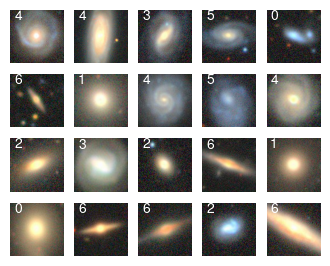

In [27]:
images, targets = load_images()

print(f'number of images: {len(images):d}')

plot_images(images, targets)

## Prepare training and validation datasets
  1. Split data into training, testing, and validation sets.
  2. Change shape of tensors to from $(N, H, W, C)$ to $(N, C, H, W)$.
  3. Move them to computational device.

In [5]:
n_train = 10000
n_test  =  1600
n_valid =  len(images) - n_train - n_test

# split and convert to tensors

train_x, X = torch.Tensor(images[:n_train]),  images[n_train:]
train_y, Y = torch.tensor(targets[:n_train], dtype=int), targets[n_train:]

test_x, valid_x = torch.Tensor(X[:n_test]), torch.Tensor(X[n_test:])
test_y, valid_y = torch.tensor(Y[:n_test], dtype=int), torch.tensor(Y[n_test:], dtype=int)

# change shape ( (N, H, W, C) => (N, C, H, W) ) and send to computational device

train_x = train_x.transpose(2,3).transpose(1,2).to(DEVICE)
train_y = train_y.to(DEVICE)

valid_x = valid_x.transpose(2,3).transpose(1,2).to(DEVICE)
valid_y = valid_y.to(DEVICE)

test_x  = test_x.transpose(2,3).transpose(1,2).to(DEVICE)
test_y  = test_y.to(DEVICE)

print()
print(train_x.shape)
print(train_y.shape)
print()

print("number of images for training:   %10d, %10d" % (len(train_x), len(train_y)))
print("number of images for testing:    %10d, %10d" % (len(test_x),  len(test_y)))
print("number of images for validation: %10d, %10d" % (len(valid_x), len(valid_y)))


torch.Size([10000, 3, 96, 96])
torch.Size([10000])

number of images for training:        10000,      10000
number of images for testing:          1600,       1600
number of images for validation:       1000,       1000


In [22]:
type(train_y)

torch.Tensor

### Load Model

In [6]:
import CAE as NN
importlib.reload(NN)

model = NN.model.to(DEVICE)

print(model)

print('number of parameters:', NN.number_of_parameters(model))

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 12, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(12, 8, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(8, 4, kernel_size=(2,

In [7]:
def get_random_batch(x, batch_size):
    indices = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[indices]

In [8]:
def train(model, optimizer, getbatch, loss_fn, train_x, batch_size):
    
    model.train()

    # get a batch of training data
    x = getbatch(train_x, batch_size)
    
    # compute model
    pred_x = model(x)

    # compute loss functions, given the model outputs and the targets
    loss = loss_fn(pred_x, x)
    
    optimizer.zero_grad()  # clear previous gradients
    
    loss.backward()        # compute gradients
    
    optimizer.step()       # move one step
        
def validate(model, loss_fn, train_x, valid_x):
    
    n_valid = len(valid_x)
    
    model.eval()
    
    with torch.no_grad():  # no need to compute gradients wrt. to x, t

        # compute model
        pred_x = model(train_x[:n_valid])
        loss_t = loss_fn(pred_x, train_x[:n_valid]).data.cpu()

        pred_x = model(valid_x)
        loss_v = loss_fn(pred_x, valid_x).data.cpu()

    return loss_t, loss_v
               
def trainModel(model, optimizer, getbatch, averageloss, modelfile,
               train_x, valid_x, 
               n_iterations, batch_size, 
               xx=[], yy_t=[], yy_v=[], step=100):

    min_loss_v = 1e30
    print('%10s\t%10s\t%10s' % ('iteration', 'training', 'validation'))
    
    for ii in range(n_iterations):
        
        train(model, optimizer, getbatch, averageloss, train_x, batch_size)

        if ii % step == 0:
            
            loss_t, loss_v = validate(model, averageloss, train_x, valid_x)
            
            print("\r%10d\t%10.6f\t%10.6f" % (ii, loss_t, loss_v), end='')

            if len(xx) < 1:
                xx.append(0)
            else:
                xx.append(xx[-1]+step)
            yy_t.append(loss_t)
            yy_v.append(loss_v)
            
        if loss_v < min_loss_v:
            min_loss_v = loss_v
            torch.save(model.state_dict(), modelfile)
            
    print()
    return xx, yy_t, yy_v

## Train

In [9]:
def plot(x, y_t, y_v):
    # create an empty figure
    fig = plt.figure(figsize=(5, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title('Training and Validation Loss', fontsize=16)

    # axis limits
    ax.set_xlim((x[0], x[-1]))
    ax.set_xlabel('Iterations', fontsize=14)
    
    ax.set_ylabel('loss', fontsize=14)
    ax.set_yscale('log')
    
    ax.plot(x, y_t, 'b', label='Training')
    ax.plot(x, y_v, 'r', label='Validation')

    ax.grid(True, which="both", linestyle='-')

    ax.legend(loc='lower right')
    
    fig.tight_layout()
    plt.savefig('loss.png')
    plt.show()

In [10]:
xx   = []  # iteration numbers
yy_t = []  # prediction accuracy using training data
yy_v = []  # prediction accuracy using validation data

In [11]:
TRAIN = False

avloss = nn.MSELoss()

if TRAIN:
    
    n_iter  =200000    # number of iterations
    n_batch =    32     # number of images/training batch
    step    =   100
    learning_rate = 1.0e-3
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    xx, yy_t, yy_v = trainModel(model, optimizer, get_random_batch, avloss, 
                                MODELFILE,
                                train_x, valid_x, 
                                n_iter,  n_batch, 
                                xx, yy_t, yy_v, 
                                step=step)
    
    print("\ndone!")
    plot(xx, yy_t, yy_v)

## Apply model to test data
We'll use a model trained on a GPU.

In [12]:
import CAEcuda as NN
importlib.reload(NN)

MODELFILE = 'CAEcuda.dict' # file containing parameters of trained model

model = NN.model.to(DEVICE)

print(model)

print('number of parameters:', NN.number_of_parameters(model))

model.load_state_dict(torch.load(MODELFILE, map_location=torch.device(DEVICE)))

loss_t, loss_v = validate(model, avloss, train_x, valid_x)
loss_t, loss_v

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(24, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 24, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(24, 12, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(12, 6, kernel_size=(2

(tensor(0.0024), tensor(0.0024))

ORIGINAL
images.shape (1600, 96, 96, 3) <class 'torch.Tensor'>


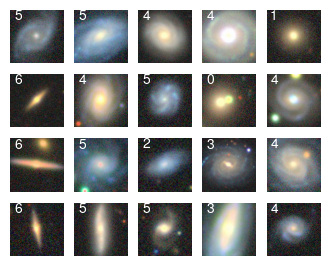

RECONSTRUCTED
images.shape (1600, 96, 96, 3) <class 'torch.Tensor'>


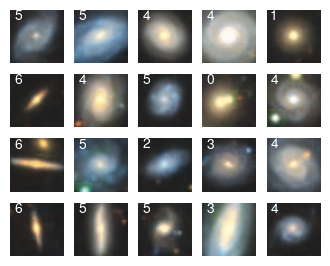

ENCODED
images.shape (1600, 24, 24, 1) <class 'torch.Tensor'>


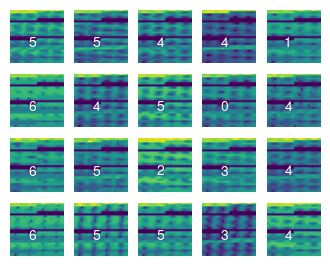

In [29]:
model.eval()

enc_x  = model.encoder(test_x)
pred_x = model.decoder(enc_x)

print('ORIGINAL')
plot_images(test_x, test_y, filename='galaxies_test_set.png')

print('RECONSTRUCTED')
plot_images(pred_x, test_y, filename='galaxies_test_set_CAE.png')

print('ENCODED')
plot_images(enc_x.reshape(-1, 1, 24, 24),  
            test_y, filename='galaxies_test_set_CAE_latent.png')

# Anomaly Detection

In [30]:
def test_statistic(x, y):
    
    N, C, H, W = x.shape

    X = x.reshape(N, C*H*W).detach().cpu().numpy()
    Y = y.reshape(N, C*H*W).detach().cpu().numpy()

    return np.mean((X-Y)**2, axis=1)

In [31]:
t = test_statistic(pred_x, test_x)
t.sort()
t.min(), t.mean(), t.std(), t.max()

(0.00029742732, 0.0024350523, 0.0010359035, 0.007634865)

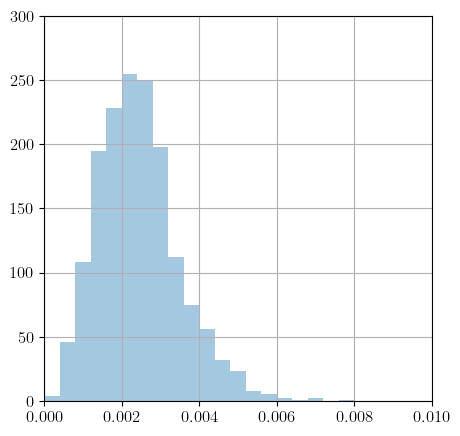

In [32]:
def plot_test_statistic(x, 
              filename='dist_loss.png', 
              f_size=(5, 5)):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=f_size)

    xbins = 25
    xmin, xmax = 0, 0.01
    ymin, ymax = 0, 300

    ax.set_xlim((xmin, xmax))
    
    ax.set_ylim((ymin, ymax))

    ax.hist(x, bins=xbins, range=(xmin, xmax), alpha=0.4)

    ax.grid()
    
    plt.savefig(filename)
    
    plt.show()

plot_test_statistic(t)

### Add anomalies to photos

images.shape (1600, 96, 96, 3) <class 'torch.Tensor'>


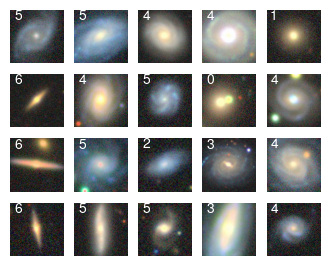

images.shape (1600, 96, 96, 3) <class 'torch.Tensor'>


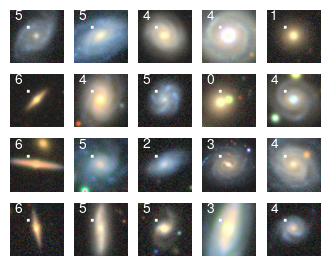

In [37]:
from copy import deepcopy
z = deepcopy(test_x)

M = 30
N = 20
ii = np.linspace(0, N-1, N)
z[ii, 0, M:M+5, M:M+5] = 1.0
z[ii, 1, M:M+5, M:M+5] = 1.0
z[ii, 2, M:M+5, M:M+5] = 1.0

plot_images(test_x, test_y, filename='galaxies.png')
plot_images(z, test_y, filename='galaxies_with_anomalies.png')

In [39]:
model.eval()
pred_z = model(z)
t_z = test_statistic(pred_z[:N], z[:N])
t_z

array([0.00275372, 0.00188254, 0.00087988, 0.00083271, 0.00324604,
       0.00280889, 0.0021363 , 0.00363513, 0.00310808, 0.00184486,
       0.00380208, 0.00252473, 0.00331895, 0.00218046, 0.00222935,
       0.00549796, 0.00313919, 0.00403918, 0.00089235, 0.00441085],
      dtype=float32)

In [245]:
import iminuit as mn
import scipy.stats as st
import scipy.optimize as op
import scipy.special as sp

In [283]:
mean = t.mean()
std  = t.std()

class Res:
    pass
res = Res()

res.x = np.array([mean, std, 0, 0, 1])

res.x

array([0.04821072, 0.01052516, 0.        , 0.        , 1.        ])

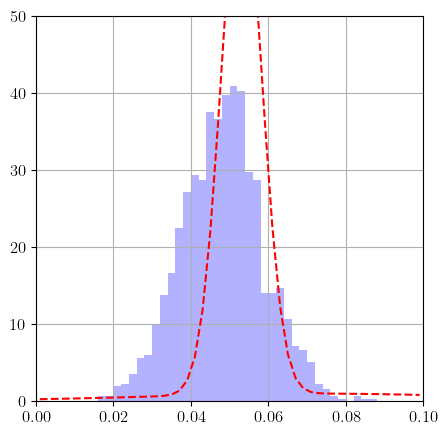

    0.0230	      2.19	      0.48
    0.0250	      3.44	      0.50
    0.0270	      5.62	      0.53
    0.0290	      5.94	      0.56
    0.0310	     10.00	      0.60
    0.0330	     13.75	      0.66
    0.0350	     16.56	      0.83
    0.0370	     22.50	      1.33
    0.0390	     27.19	      2.64
    0.0410	     29.37	      5.72
    0.0430	     28.75	     11.83
    0.0450	     37.50	     22.06
    0.0470	     36.56	     36.17
    0.0490	     39.69	     51.69
    0.0510	     40.94	     64.16
    0.0530	     40.31	     69.08
    0.0550	     29.69	     64.49
    0.0570	     28.75	     52.23
    0.0590	     14.06	     36.77
    0.0610	     14.06	     22.60
    0.0630	     14.69	     12.27
    0.0650	     10.63	      6.07
    0.0670	      7.19	      2.95
    0.0690	      6.56	      1.63
    0.0710	      5.00	      1.15
    0.0730	      2.19	      1.00


In [331]:
XMIN = 0
XMAX = 0.1
XBINS=50
XSTEP=(XMAX-XMIN)/XBINS

def F1(x, a1, b1):
    return st.norm.pdf(x, loc=a1, scale=b1)

def F2(x, a1, b1, a2, b2, c):
    f1 = st.norm.pdf(x, loc=a1, scale=b1)
    f2 = st.norm.pdf(x, loc=a2, scale=b2) if c < 1 else np.zeros(len(x))
    return c * f1 + (1 - c) * f2

def plot_hist(x, res, func, 
              xbins=XBINS, xmin=XMIN, xmax=XMAX,
              ymin=0, ymax=50,
              filename='dist_loss.png', 
              f_size=(5, 5)):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=f_size)

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    y, z, _ = ax.hist(x, bins=xbins, range=(xmin, xmax), 
                      color='blue', alpha=0.3, density=True)
    z = (z[1:] + z[:-1])/2
    f = func(z, *res.x)
    
    ax.plot(z, f, color='red', linestyle='dashed')
    ax.grid()

    plt.savefig(filename)
    
    plt.show()

    return z, y, f
    
res = Res()
res.x = np.array([1.1*mean, std/2, 1.5*mean, 4*std, 0.9])
X, Y, F = plot_hist(t, res, F2)
S = Y > 2

X = X[S]
Y = Y[S]
F = F[S]

for x, y, f in zip(X, Y, F):
    print(f'{x:10.4f}\t{y:10.2f}\t{f:10.2f}')

a1 0.04821071773767471
b1 0.010525158606469631
f [ 2.15192236  3.33162837  4.97513674  7.16591971  9.95537097 13.34017509
 17.24185421 21.49438152 25.84547694 29.97523972 33.53198748 36.18048983
 37.65373881 37.79725717 36.59577778 34.17591843 30.78420367 26.74571629
 22.41295344 18.11600353 14.12355784 10.62048718  7.70306001  5.3889064
  3.63627607  2.36663493]
y [ 2.18749964  3.43749944  5.62499908  5.93750456  9.99998905 13.74999775
 16.56252814 22.49999631 27.18749554 29.37499519 28.74999529 37.49999385
 36.56249401 39.68749349 40.93749329 40.31249339 29.68749513 28.75004884
 14.06249769 14.06249769 14.68747023 10.62501805  7.18748543  6.56251115
  5.00000849  2.18749557]

a1 0.048210727737674715
b1 0.010525158606469631
f [ 2.15191747  3.33162139  4.97512722  7.16590728  9.9553555  13.34015677
 17.24183365 21.49435977 25.84545545 29.9752202  33.53197171 36.18047935
 37.65373469 37.79725986 36.595787   34.17593321 30.78422254 26.74573751
 22.41297527 18.11602445 14.12357669 10.6205

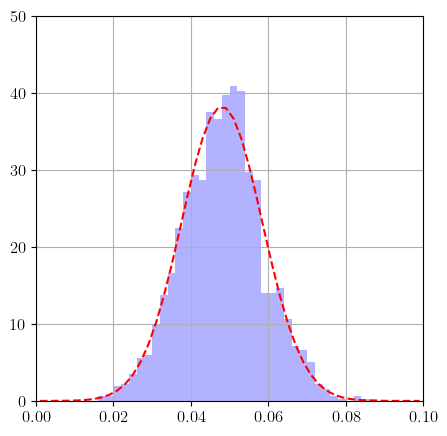

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 9.560944523707397
        x: [ 4.798e-02  1.044e-02]
      nit: 4
      jac: [-5.720e-04  8.994e-04]
     nfev: 21
     njev: 7
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [327]:
def nll1(params, *args):
    
    a1, b1  = params
    x, y, g = args
    
    f = g(x, a1, b1)

    print('a1', a1)
    print('b1', b1)
    print('f', f)
    print('y', y)
    print()

    Q = (y-f)**2 / y
    Q = Q.sum()

    return Q

def nll(params, *args):
    
    a1, b1, a2, b2, c = params
    x, y, g = args
    
    f = g(x, a1, b1, a2, b2, c)
    
    Q = (y-f)**2 / y
    Q = Q.sum()

    return Q

from scipy.optimize import Bounds

guess = res.x

limits = Bounds([mean/5, std/5, mean/5, std/5, 0], 
                [mean*5, std*5, mean*5, std*5, 1])

results = op.minimize(nll1, guess, args=(X, Y, F1), bounds=limits)

plot_hist(t, results, F1)

results

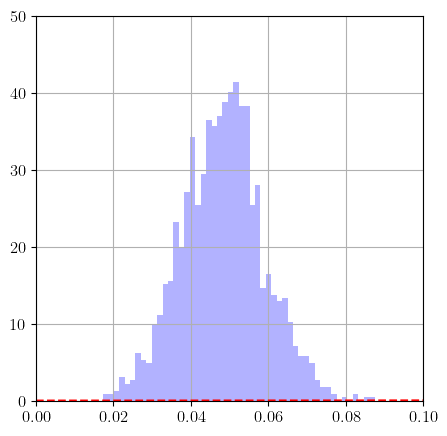